In [233]:
import faiss
import matplotlib.pyplot as plt
import numpy as np
import opt_einsum as oe
import pandas as pd
import seaborn as sns

import prfr

In [206]:
def hnsw_regression(
    x_train, y_train, x_test, M=128, ef_search=128, ef_construction=128, neighbours=5
):
    if x_train.ndim == 1:
        x_train = x_train.reshape(-1, 1)
    if x_test.ndim == 1:
        x_test = x_test.reshape(-1, 1)
    m = x_train.mean(axis=0)
    s = x_train.std(axis=0)
    print(s)
    ndim = x_train.shape[1]
    index = faiss.IndexHNSWFlat(ndim, M)
    index.hnsw.efSearch = ef_search
    index.hnsw.efConstruction = ef_construction
    index.add((x_train - m) / s)
    D, I = index.search((x_test - m) / s, neighbours + 1)
    w = 1 / (D + np.sqrt(1e-7))
    w /= w.sum(axis=1)[:, None]
    pred = oe.contract("ij, ij -> i", y_train[I], w)
    return pred, D, I

In [207]:
df = (
    pd.read_csv("../data/airfoil_self_noise.csv", delim_whitespace=1)
    .astype(np.float32)
    .sample(frac=1)
)

In [208]:
features = df.iloc[:, :5].to_numpy()
labels = df.iloc[:, -1].to_numpy()
train, test = prfr.split_arrays(features, labels, test_size=0.2)

[3.2047847e+03 5.9080644e+00 9.3411438e-02 1.5613478e+01 1.3153048e-02]
CPU times: user 925 ms, sys: 0 ns, total: 925 ms
Wall time: 26.5 ms


Text(0.05, 0.85, 'Bias=-0.31\nScatter=2.08')

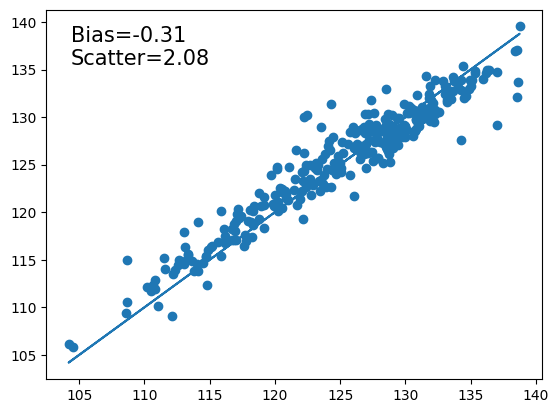

In [209]:
%time pred = hnsw_regression(train[0], train[1], test[0])[0]
res = test[1] - pred
plt.scatter(test[1], pred)
plt.plot(test[1], test[1])
plt.annotate(
    f"Bias={res.mean():.2f}\nScatter={res.std():.2f}",
    xy=(0.05, 0.85),
    xycoords="axes fraction",
    fontsize=15,
)

In [211]:
clf = prfr.ProbabilisticRandomForestRegressor(n_jobs=-1)
clf.fit(train[0], train[1])

Fitting model:   0%|          | 0/100 [00:00<?, ?it/s]

ProbabilisticRandomForestRegressor(n_jobs=-1)

In [212]:
pred2 = clf.predict(test[0])[:, 0]

Predicting:   0%|          | 0/100 [00:00<?, ?it/s]

Text(0.05, 0.85, 'Bias=0.08\nScatter=1.55')

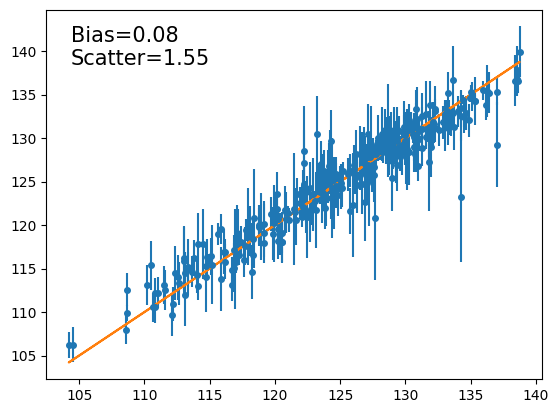

In [213]:
res2 = test[1] - pred2.mean(axis=-1)
plt.errorbar(
    test[1],
    np.median(pred2, axis=-1),
    yerr=np.std(pred2, axis=-1),
    ls="none",
    marker="o",
    ms=4,
)
plt.plot(test[1], test[1])
plt.annotate(
    f"Bias={res2.mean():.2f}\nScatter={res2.std():.2f}",
    xy=(0.05, 0.85),
    xycoords="axes fraction",
    fontsize=15,
)

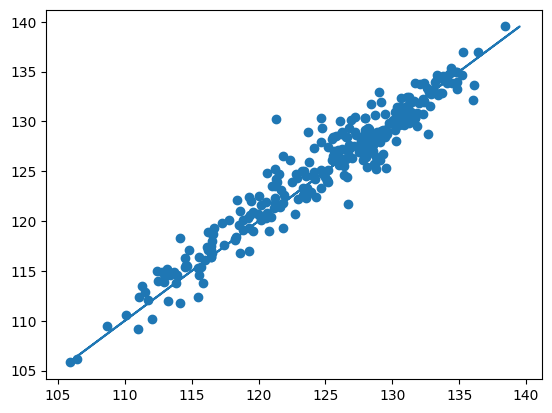

In [214]:
plt.scatter(pred2.mean(axis=-1), pred)
plt.plot(pred, pred)

[3.0066614]


Fitting model:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting:   0%|          | 0/100 [00:00<?, ?it/s]

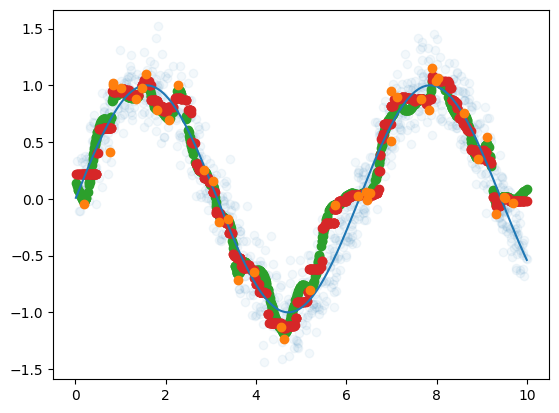

In [231]:
np.random.seed(4)
x = np.random.uniform(0, 10, size=1000).astype("float32")
x = np.sort(x)
y = np.sin(x)
yn = y + np.random.normal(size=1000) * 0.2
it = np.random.choice(1000, size=40, replace=False)
xt = x[it]
yt = yn[it]
plt.plot(x, y)
plt.scatter(x, yn, alpha=0.05)
plt.scatter(xt, yt, zorder=5)
p, d, i = hnsw_regression(xt, yt, x, neighbours=20)
clf = prfr.ProbabilisticRandomForestRegressor()
clf.fit(xt.reshape(-1, 1), yt)
p2 = clf.predict(x.reshape(-1, 1))[:, 0].mean(axis=-1)
plt.scatter(x, p)
plt.scatter(x, p2)

<AxesSubplot:ylabel='Count'>

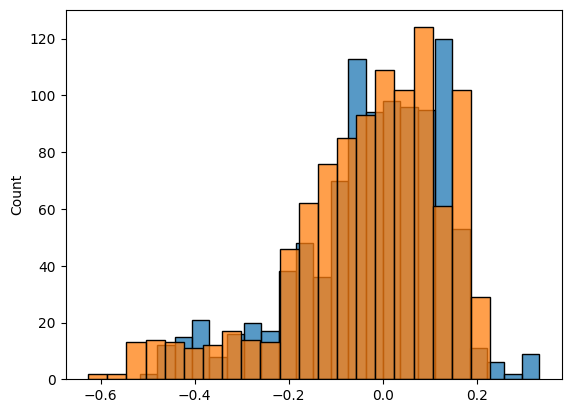

In [238]:
sns.histplot(y - p2)
sns.histplot(y - p)

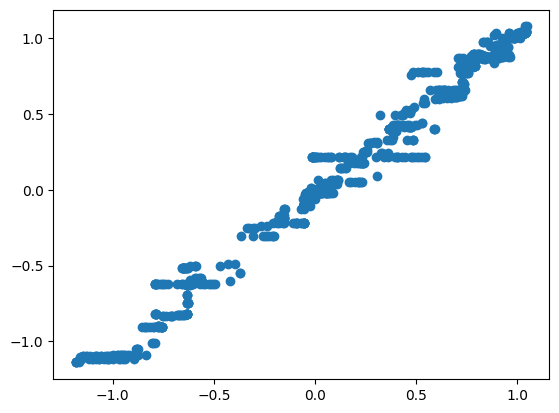

In [232]:
plt.scatter(p, p2)

In [215]:
red = pd.read_csv("../data/winequality-red.csv", delimiter=";")
white = pd.read_csv("../data/winequality-white.csv", delimiter=";")
wine = pd.concat((red, white), ignore_index=1).sample(frac=1)

In [216]:
features, labels = wine.iloc[:, :-1].to_numpy().astype("float32"), wine.iloc[
    :, -1
].to_numpy().astype("float32")
train, test = prfr.split_arrays(features, labels, test_size=0.2)

[1.2903972e+00 1.6486780e-01 1.4561561e-01 4.7219877e+00 3.4668922e-02
 1.7369913e+01 5.6268204e+01 3.0074427e-03 1.6040654e-01 1.4941481e-01
 1.1939948e+00]


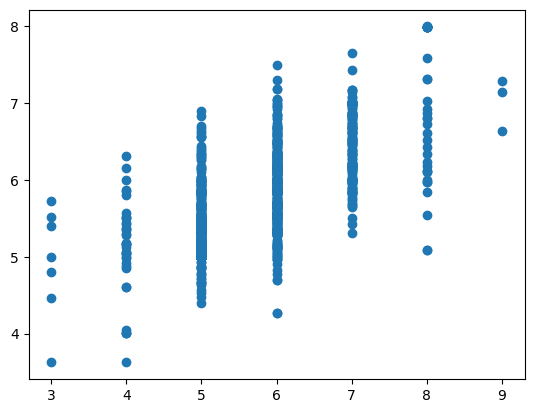

In [219]:
pred, d, i = hnsw_regression(train[0], train[1], test[0])
plt.scatter(test[1], pred)

In [221]:
clf = prfr.ProbabilisticRandomForestRegressor(n_jobs=-1)
clf.fit(train[0], train[1])

Fitting model:   0%|          | 0/100 [00:00<?, ?it/s]

ProbabilisticRandomForestRegressor(n_jobs=-1)

In [223]:
pred2 = clf.predict(test[0])[:, 0]

Predicting:   0%|          | 0/100 [00:00<?, ?it/s]

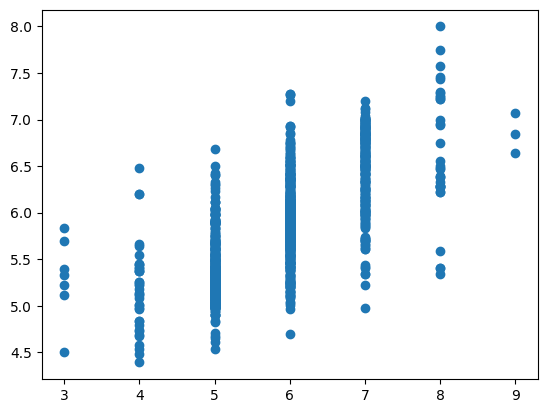

In [224]:
plt.scatter(test[1], pred2.mean(axis=-1))

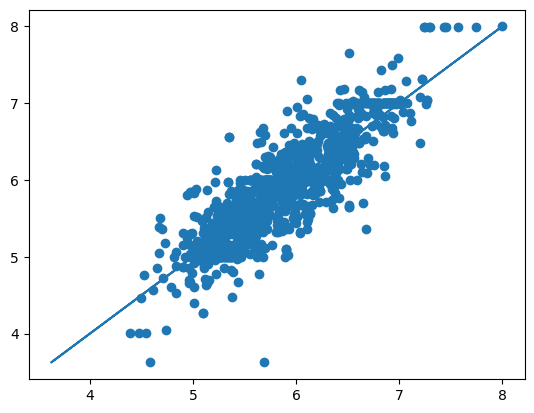

In [226]:
plt.scatter(pred2.mean(axis=-1), pred)
plt.plot(pred, pred)